In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('./drive/MyDrive/FR/faster_rcnn_classification/')
import torch

if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

Mounted at /content/drive
There are 1 GPU(s) available.
We will use the GPU: Tesla T4


## Load data


In [ ]:
!git clone https://github.com/Pseudo-Lab/Tutorial-Book-Utils
!python Tutorial-Book-Utils/PL_data_loader.py --data FaceMaskDetection
!unzip -q Face\ Mask\ Detection.zip

fatal: destination path 'Tutorial-Book-Utils' already exists and is not an empty directory.
Downloading...
From: https://drive.google.com/uc?id=1pJtohTc9NGNRzHj5IsySR39JIRPfkgD3
To: /content/drive/My Drive/FR/faster_rcnn_classification/Face Mask Detection.zip
100% 417M/417M [00:06<00:00, 66.6MB/s]
Face Mask Detection.zip download complete!
replace annotations/maksssksksss0.xml? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

## Data split

In [ ]:
import os
import random
import numpy as np
import shutil
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from PIL import Image
import torchvision
from torchvision import transforms, datasets, models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import time
import pandas as pd


In [ ]:
print(len(os.listdir('annotations')))
print(len(os.listdir('images')))

!mkdir test_images
!mkdir test_annotations


random.seed(1234)
idx = random.sample(range(853), 170)

for img in np.array(sorted(os.listdir('images')))[idx]:
    shutil.move('images/'+img, 'test_images/'+img)

for annot in np.array(sorted(os.listdir('annotations')))[idx]:
    shutil. ('annotations/'+annot, 'test_annotations/'+annot)

print(len(os.listdir('annotations')))
print(len(os.listdir('images')))
print(len(os.listdir('test_annotations')))
print(len(os.listdir('test_images')))

853
853
mkdir: cannot create directory ‘test_images’: File exists
mkdir: cannot create directory ‘test_annotations’: File exists
683
683
170
170


## Definition

In [ ]:
temp = pd.read_xml('./annotations/maksssksksss0.xml')
temp.keys()

Index(['folder', 'filename', 'width', 'height', 'depth', 'segmented', 'name',
       'pose', 'truncated', 'occluded', 'difficult', 'bndbox'],
      dtype='object')

In [ ]:
def generate_box(obj):
    
    xmin = float(obj.find('xmin').text)
    ymin = float(obj.find('ymin').text)
    xmax = float(obj.find('xmax').text)
    ymax = float(obj.find('ymax').text)
    
    return [xmin, ymin, xmax, ymax]

adjust_label = 1


## label 만드는 함수, with_mask 유무와 None, 총 3개의 label로 분류함 | with mask는 2 without mask는 3 defal=ult는 1이고 transfer learning되는애가 0인듯
def generate_label(obj):

    if obj.find('name').text == "with_mask":

        return 1 + adjust_label

    elif obj.find('name').text == "mask_weared_incorrect":

        return 2 + adjust_label

    return 0 + adjust_label

def generate_target(file): 
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, "html.parser")
        objects = soup.find_all("object")

        num_objs = len(objects)

        boxes = []
        labels = []
        for i in objects:
            boxes.append(generate_box(i))
            labels.append(generate_label(i))

        boxes = torch.as_tensor(boxes, dtype=torch.float32) 
        labels = torch.as_tensor(labels, dtype=torch.int64) 
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        
        return target

def plot_image_from_output(img, annotation):
    
    img = img.cpu().permute(1,2,0)
    
    fig,ax = plt.subplots(1)
    ax.imshow(img)
    
    for idx in range(len(annotation["boxes"].cpu())):
        xmin, ymin, xmax, ymax = annotation["boxes"][idx].cpu()

        if annotation['labels'][idx] == 1 :
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')
        
        elif annotation['labels'][idx] == 2 :
            
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='g',facecolor='none')
            
        else :
        
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='orange',facecolor='none')

        ax.add_patch(rect)

    plt.show()
class MaskDataset(object):
    def __init__(self, transforms, path):
        '''
        path: path to train folder or test folder
        '''
        # transform module과 img path 경로를 정의
        self.transforms = transforms
        self.path = path
        self.imgs = list(sorted(os.listdir(self.path)))


    def __getitem__(self, idx): #special method
        # load images ad masks
        file_image = self.imgs[idx]
        file_label = self.imgs[idx][:-3] + 'xml'
        img_path = os.path.join(self.path, file_image)
        
        if 'test' in self.path:
            label_path = os.path.join("test_annotations/", file_label)
        else:
            label_path = os.path.join("annotations/", file_label)

        img = Image.open(img_path).convert("RGB")
        #Generate Label
        target = generate_target(label_path)
        
        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self): 
        return len(self.imgs)

data_transform = transforms.Compose([  # transforms.Compose : list 내의 작업을 연달아 할 수 있게 호출하는 클래스
        transforms.ToTensor() # ToTensor : numpy 이미지에서 torch 이미지로 변경
    ])

def collate_fn(batch):
    return tuple(zip(*batch))

def get_model_instance_segmentation(num_classes):
  
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model
    
dataset = MaskDataset(data_transform, 'images/')
test_dataset = MaskDataset(data_transform, 'test_images/')

data_loader = torch.utils.data.DataLoader(dataset, batch_size=4, collate_fn=collate_fn)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=4, collate_fn=collate_fn)


##Transfer learning

In [ ]:
model = get_model_instance_segmentation(4)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') 
model.to(device)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
from torch.cuda.amp import GradScaler
from torch.cuda.amp import autocast
scaler = GradScaler()
num_epochs = 150
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)

In [ ]:
# model.load_state_dict(torch.load('./weights/faster_rcnn_resnet50_125ep.pt'))
model.load_state_dict(torch.load('./weights/faster_rcnn_resnet50_100ep.pt'))


<All keys matched successfully>

# TRAIN

In [ ]:
import copy

print('----------------------train start--------------------------')
model.train(); model.cuda();
final_model = None
# start_epoch = 0
start_epoch = 100
best_ep = 0; best_loss =10.5


for epoch in range(start_epoch, num_epochs):
    start = time.time()
    model.train()
    i = 0    
    epoch_loss = 0
    for imgs, annotations in data_loader:
        i += 1
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        with autocast(enabled=True):
          loss_dict = model(imgs, annotations) 
          losses = sum(loss for loss in loss_dict.values())        

          optimizer.zero_grad()
          # losses.backward()
          # optimizer.step() 
          scaler.scale(losses).backward()
          scaler.step(optimizer)
          scaler.update()
          epoch_loss += losses
    print(f'epoch : {epoch+1}, Loss : {epoch_loss}, time : {time.time() - start}')

    if epoch_loss < best_loss :
      best_loss = epoch_loss
      best_ep = epoch+1
      final_model = copy.deepcopy(model)

    if epoch-best_ep > 15 : break

----------------------train start--------------------------
epoch : 101, Loss : 9.877124786376953, time : 140.38136792182922
epoch : 102, Loss : 9.277329444885254, time : 142.33821201324463
epoch : 103, Loss : 9.65834903717041, time : 142.43200850486755
epoch : 104, Loss : 10.778631210327148, time : 142.2219614982605
epoch : 105, Loss : 11.017663955688477, time : 142.42382955551147
epoch : 106, Loss : 10.966280937194824, time : 142.39040756225586
epoch : 107, Loss : 11.50064468383789, time : 142.41246962547302
epoch : 108, Loss : 10.598592758178711, time : 142.38185572624207
epoch : 109, Loss : 10.145855903625488, time : 142.26557111740112
epoch : 110, Loss : 9.779603958129883, time : 142.16815662384033
epoch : 111, Loss : 9.780410766601562, time : 142.51659059524536
epoch : 112, Loss : 10.00834846496582, time : 142.06021642684937
epoch : 113, Loss : 9.59081745147705, time : 141.7092354297638
epoch : 114, Loss : 9.473166465759277, time : 142.19865250587463
epoch : 115, Loss : 9.5984010

In [ ]:
import cv2

def plot_image_from_output(img, annotation):
    
    img = img.cpu().permute(1,2,0)
    
    fig,ax = plt.subplots(1)
    # ax.imshow(img)
    
    for idx in range(len(annotation["boxes"].cpu())):
        xmin, ymin, xmax, ymax = annotation["boxes"][idx].cpu()

        if annotation['labels'][idx] == 1 :
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')
        
        elif annotation['labels'][idx] == 2 :
            
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='g',facecolor='none')
            
        else :
        
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='orange',facecolor='none')

        ax.add_patch(rect)
        # print(xmin)
        croped = img[int(ymin):int(ymax), int(xmin):int(xmax), :]
        ax.imshow(croped)
        plt.show()
    return croped


class temp_MaskDataset(object):
    def __init__(self, transforms, path):
        '''
        path: path to train folder or test folder
        '''
        # transform module과 img path 경로를 정의
        self.transforms = transforms
        self.path = path
        temp = []; self.names = []
        for a,b,c in os.walk(path):
          for _c in c :
            file = os.path.join(a,_c)
            temp.append(file)
            self.names.append(_c.split('.')[0])
        self.full = temp
        print(temp)

    def __getitem__(self, idx): #special method
        img_path = self.full[idx]
        print(img_path)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        if self.transforms is not None:
            img = self.transforms(img)
        return img, self.names[idx]

    def __len__(self): 
        return len(self.full)
        

data_transform = transforms.Compose([  # transforms.Compose : list 내의 작업을 연달아 할 수 있게 호출하는 클래스
        transforms.ToTensor() # ToTensor : numpy 이미지에서 torch 이미지로 변경
    ])
test_dataset = temp_MaskDataset(data_transform, 'dataset_with_background/')
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1)

   

['dataset_with_background/0_1_gwang_0.png', 'dataset_with_background/0_1_gwang_1.png', 'dataset_with_background/0_1_gwang_2.png', 'dataset_with_background/0_1_gwang_3.png', 'dataset_with_background/0_1_gwang_4.png', 'dataset_with_background/0_1_gwang_5.png', 'dataset_with_background/0_1_gwang_6.png', 'dataset_with_background/0_1_gwang_7.png', 'dataset_with_background/0_1_gwang_8.png', 'dataset_with_background/0_1_gwang_9.png', 'dataset_with_background/0_1_gwang_10.png', 'dataset_with_background/0_1_gwang_11.png', 'dataset_with_background/0_1_gwang_12.png', 'dataset_with_background/0_1_gwang_13.png', 'dataset_with_background/0_1_gwang_14.png', 'dataset_with_background/0_1_gwang_15.png', 'dataset_with_background/0_1_gwang_16.png', 'dataset_with_background/0_1_gwang_17.png', 'dataset_with_background/0_1_gwang_18.png', 'dataset_with_background/0_1_gwang_19.png', 'dataset_with_background/0_1_gwang_20.png', 'dataset_with_background/0_1_gwang_21.png', 'dataset_with_background/0_1_gwang_22.png

In [ ]:
import glob
list_folder = glob.glob('./dataset_facial/dataset_facial_real/*')

In [ ]:
temp = []
for a,b,c in os.walk('./dataset_facial/dataset_facial_real'):
  for _c in c:
    if '.png' in _c:
      temp.append(_c.split('.')[0])

In [ ]:

def make_prediction(model, img, threshold):
    model.eval(); model.cuda()
    # img = torch.tensor(img)
    preds = model(img)

    for id in range(len(preds)) :
        idx_list = []

        for idx, score in enumerate(preds[id]['scores']) :
            if score > threshold : 
                idx_list.append(idx)

        preds[id]['boxes'] = preds[id]['boxes'][idx_list]
        preds[id]['labels'] = preds[id]['labels'][idx_list]
        preds[id]['scores'] = preds[id]['scores'][idx_list]

    return preds

root = './dataset_facial/dataset_facial_real/'
os.makedirs(root,exist_ok=True)

transform =transforms.ToPILImage()
with torch.no_grad(): 
    # 테스트셋 배치사이즈= 2
    for imgs, names in test_data_loader:
      # print(names)
      if names[0] in temp : continue
      starttime = time.time()
      imgs = imgs.to(device)
      pred = make_prediction(model, imgs, 0.5)
      endtime = time.time()
      print(endtime-starttime)

      for _idx in range(len(pred)):
        print("Prediction : ", pred[_idx]['labels'])
        cropped = plot_image_from_output(imgs[_idx], pred[_idx])
        # print(names)
        img = np.array(cropped*255)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        cv2.imwrite(root+names[0]+'.png', img)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
torch.save(final_model.state_dict(),f'faster_rcnn_resnet50_{best_ep}ep.pt')

In [ ]:
model.load_state_dict(torch.load(f'model_{best_ep}.pt'))
model.eval()

## Estimation

In [ ]:
def make_prediction(model, img, threshold):
    model.eval()
    preds = model(img)
    for id in range(len(preds)) :
        idx_list = []

        for idx, score in enumerate(preds[id]['scores']) :
            if score > threshold : 
                idx_list.append(idx)

        preds[id]['boxes'] = preds[id]['boxes'][idx_list]
        preds[id]['labels'] = preds[id]['labels'][idx_list]
        preds[id]['scores'] = preds[id]['scores'][idx_list]

    return preds
with torch.no_grad(): 
    # 테스트셋 배치사이즈= 2
    for imgs, annotations in test_data_loader:
        imgs = list(img.to(device) for img in imgs)

        pred = make_prediction(model, imgs, 0.5)
        # print(pred)
        break

Target :  tensor([2])


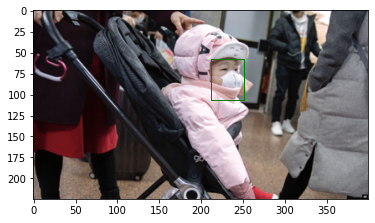

Prediction :  tensor([2, 2], device='cuda:0')


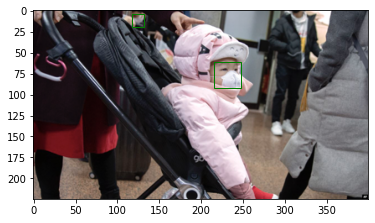

Target :  tensor([1, 1, 1, 2, 2, 1, 1, 1])


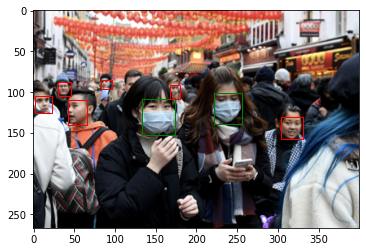

Prediction :  tensor([2, 2, 1, 1, 1, 1, 1, 1], device='cuda:0')


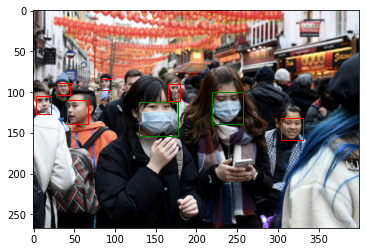

Target :  tensor([1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 2, 2, 1,
        1, 2])


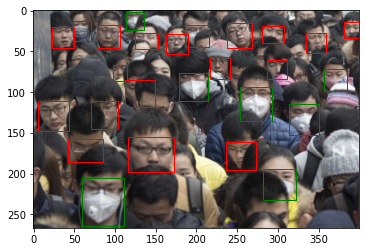

Prediction :  tensor([2, 1, 2, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1,
        2], device='cuda:0')


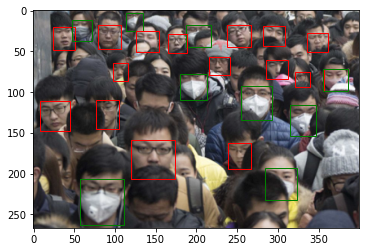

Target :  tensor([3])


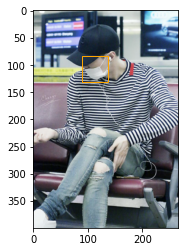

Prediction :  tensor([2, 3], device='cuda:0')


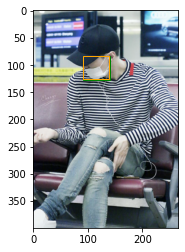

IndexError: ignored

In [ ]:
idxs = np.arange(len(annotations))
for _idx in idxs:
  print("Target : ", annotations[_idx]['labels'])
  plot_image_from_output(imgs[_idx], annotations[_idx])
  print("Prediction : ", pred[_idx]['labels'])
  plot_image_from_output(imgs[_idx], pred[_idx])

In [ ]:
from tqdm import tqdm

labels = []
preds_adj_all = []
annot_all = []

for im, annot in tqdm(test_data_loader, position = 0, leave = True):
    im = list(img.to(device) for img in im)
    #annot = [{k: v.to(device) for k, v in t.items()} for t in annot]

    for t in annot:
        labels += t['labels']

    with torch.no_grad():
        preds_adj = make_prediction(model, im, 0.5)
        preds_adj = [{k: v.to(torch.device('cpu')) for k, v in t.items()} for t in preds_adj]
        preds_adj_all.append(preds_adj)
        annot_all.append(annot)


100%|██████████| 43/43 [00:28<00:00,  1.49it/s]


- Tutorial-Book-Utils 폴더 내에 있는 utils_ObjectDetection.py 파일을 통해서 mAP 값을 산출합니다. `get_batch_statistics` 함수를 통해 IoU(Intersection of Union) 조건을 만족하는 바운딩 박스간의 통곗값을 계산후 `ap_per_class` 함수를 통해 각 클래스에 대한 AP값을 계산해줍니다.

In [ ]:
%cd Tutorial-Book-Utils/
import utils_ObjectDetection as utils

/content/drive/MyDrive/FR/faster_rcnn_classification/Tutorial-Book-Utils


In [ ]:
#100ep
sample_metrics = []
for batch_i in range(len(preds_adj_all)):
    sample_metrics += utils.get_batch_statistics(preds_adj_all[batch_i], annot_all[batch_i], iou_threshold=0.5) 

true_positives, pred_scores, pred_labels = [torch.cat(x, 0) for x in list(zip(*sample_metrics))]  # 배치가 전부 합쳐짐
precision, recall, AP, f1, ap_class = utils.ap_per_class(true_positives, pred_scores, pred_labels, torch.tensor(labels))
mAP = torch.mean(AP)
print(f'mAP : {mAP}')
print(f'AP : {AP}')

mAP : 0.7388355769320049
AP : tensor([0.8087, 0.9133, 0.4945], dtype=torch.float64)
